In [1]:
import os
import pickle
import geoplot
import seaborn as sns
import numpy as np
import itertools
import pandas as pd
import geopandas as gpd
import mapclassify as mc
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as colors
from collections import defaultdict
import cartopy
import sys
sys.path.append('C:/Users/Yamil/Proyectos/Proyectos en Git/Memoria Ambulancias/Codigos Seba')
from experiment import *

from statsmodels.nonparametric.kernel_density import *

import GeoDataProcessing.dispatchAnalysis as DA

In [2]:
DATA_DIR = 'C://Users//Yamil//Proyectos//Proyectos en Git//Memoria Ambulancias//Old files//data//'
with open(DATA_DIR + 'dispatch_data_reduced.pickle', 'rb') as f:
    df = pickle.load(f)

In [4]:
A = df.groupby([pd.cut(df['FINAL_SEVERITY_LEVEL_CODE'], [1,3,7]), 'year']).size()
A.index = A.index.set_levels([['High Severity', 'Low Severity'], [2013,2014,2015,2016,2017,2018,2019]])
sns.set_theme(style="whitegrid", font_scale = 3, font='Times New Roman')
fig, ax = plt.subplots(figsize=(15,8))
A = A.unstack()
A.index = pd.Index(['High Severity', 'Low Severity'], dtype='object', name='Severity')
A.columns = pd.Index([2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype='int64', name='Year')
ax.yaxis.get_offset_text().set_visible(False)
#A.T.plot(kind='bar', stacked=True, ax = ax, color=['#3565AD', '#4C90F7'], ylabel="Millions")
#fig.savefig('emergenciesPlot.svg')
A.sum()

Year
2013    1256387
2014    1296440
2015    1358834
2016    1390157
2017    1413867
2018    1484096
2019    1486340
dtype: int64

In [25]:
with open('D:/FTP results/friday_0_coverage_nearest_NoRelocation_Workload_0.2_NoUber_0.05_HRDemand_284ALS642BLS_600_86400_0.5.pickle', 'rb') as f:
    statistics = pickle.load(f)

In [2]:
def mapGraphNodesDataToUniformDemand(data, demand_nodes, city_nodes_df, agg='sum', default=1, value_col='value'):
    """
    With an iterable of tuples (pos, value), return a geodataframe with geometry of uniform demand nodes
    and aggregated values
    """
    data_dict = defaultdict(list)
    for d in data:
        data_dict[d[0]].append(d[1])
    data_list = [(k, v) for k, v in data_dict.items()]
    positions = [d[0] for d in data_list]
    
    new_df = demand_nodes.copy()
    new_df[value_col] = default
    
    city_nodes_df.index = city_nodes_df['osmid']

    nearest_indexes = DA.nearest_neighbor(city_nodes_df.loc[positions,:], demand_nodes, index = True)[0]

    demand_dict = defaultdict(list)
    for i, index in enumerate(nearest_indexes):
        demand_dict[index] += data_list[i][1]
    demand_list = [(k, v) for k, v in demand_dict.items()]
    positions = [d[0] for d in demand_list]
    
    new_df.index = range(len(new_df))

    if agg == 'sum':
        new_df.loc[positions, value_col] = [np.sum(d[1]) for d in demand_list]
    elif agg == 'avg':
        new_df.loc[positions, value_col] = [np.mean(d[1]) for d in demand_list]
    elif agg == 'min':
        new_df.loc[positions, value_col] = [np.min(d[1]) for d in demand_list]
    elif agg == 'max':
        new_df.loc[positions, value_col] = [np.max(d[1]) for d in demand_list]
    else:
        raise ValueError('Aggregate type not understood')

    return new_df

In [29]:
def visualizeSpatialStatistic(ax, area_shp, data, points_from_map, points_to_map, agg='avg', default=0, method='quadtree', quantile_clip=1, **kwargs):
    """
    data is expected to be a list of tuples with form (time, pos, value)
    """
    geoplot.polyplot(area_shp.simplify(0.001), ax = ax)
    points = mapGraphNodesDataToUniformDemand([(d[1], d[2]) for d in data], points_to_map, points_from_map, agg=agg, default=default)

    if quantile_clip < 1:
        points['value'] = points['value'].clip(0, points['value'].quantile(quantile_clip))
    
    if method == 'quadtree':
        geoplot.quadtree(points, clip=area_shp, nmax=1,
                         hue='value', edgecolor='white', ax=ax, projection=geoplot.crs.Mercator(), **kwargs)
    
    elif method == 'points':
        geoplot.pointplot(points, hue='value', ax=ax, **kwargs)
    
    else:
        raise('Method not understood.')
    return points

In [5]:
def visualizeStateStatisticData(data, show_mean=False):
    x = []
    y = []
    for i in range(len(data) - 1):
        if data[i][0] != data[i+1][0]:
            x.append(data[i][0])
            x.append(data[i+1][0])
            y.append(data[i][1])
            y.append(data[i][1])
    plt.plot(x, y, '-')
    
    if show_mean:
        plt.plot([0, data[-1][0]], [average()]*2, 'r-')
    
    plt.title('StateStatistic over time')
    plt.show()

In [8]:
DATA_DIR = 'C:/Users/Yamil/Proyectos/Proyectos en Git/Memoria Ambulancias/Codigos Seba/sampling_results/'
with open(DATA_DIR + 'LS19.pickle', 'rb') as f:
    dictHS = pickle.load(f)

datadir = 'C:/Users/Yamil/Proyectos/Proyectos en Git/Memoria Ambulancias/' + \
               'Old Files/Generated Shapefiles/Dispatch Demand Shapefiles/final/HSdemandsCRS.shp'
data = gpd.read_file(datadir)
#df = pd.DataFrame([[p.x, p.y] for p in data.geometry.values], columns = ['x', 'y'])

DATA_DIR = 'C:/Users/Yamil/Proyectos/Proyectos en Git/Memoria Ambulancias/Old Files/'
nyc_boundaries = gpd.read_file(DATA_DIR + 'Generated Shapefiles/NYC Subdivisions/Borough Boundaries/Borough Boundaries.shp')

print(nyc_boundaries.bounds)
print(nyc_boundaries.centroid)

#df['x'] = (df['x'] - np.min(df['x']))/(np.max(df['x']) - np.min(df['x']))
#df['y'] = (df['y'] - np.min(df['y']))/(np.max(df['y']) - np.min(df['y']))

#minx, miny, maxx, maxy = np.min(nyc_boundaries.bounds['minx']), np.min(nyc_boundaries.bounds['miny']), np.max(nyc_boundaries.bounds['maxx']), np.max(nyc_boundaries.bounds['maxy'])
#centroidx, centroidy = np.mean([p.x for p in nyc_boundaries.centroid]), np.mean([p.y for p in nyc_boundaries.centroid])

#df['x'] = df['x']*(maxx - minx) + minx
#df['y'] = df['y']*(maxy - miny) + miny

#dictHS['spatial']['stkde'].bw_dict[1]['L']

minx       miny       maxx       maxy
0 -73.933606  40.785357 -73.765332  40.915533
1 -74.255591  40.496115 -74.049236  40.648926
2 -74.041897  40.569530 -73.833559  40.739128
3 -73.962620  40.541834 -73.700009  40.801011
4 -74.047730  40.682917 -73.906651  40.879038
0    POINT (-73.86654 40.85263)
1    POINT (-74.15338 40.58085)
2    POINT (-73.94767 40.64473)
3    POINT (-73.81850 40.70759)
4    POINT (-73.96717 40.77726)
dtype: geometry


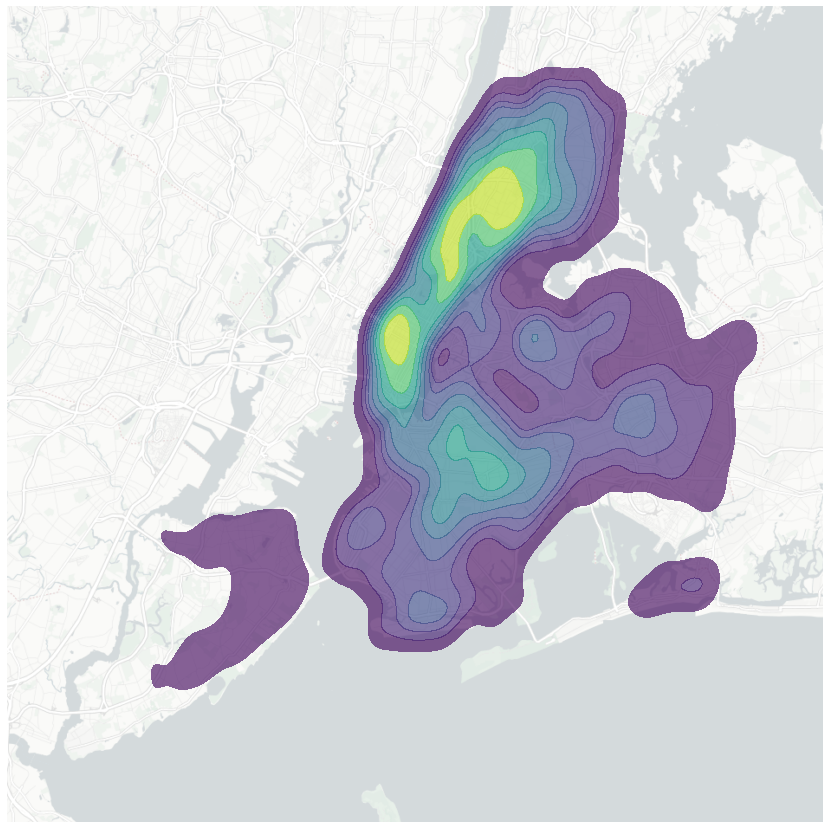

In [11]:
DATA_DIR = 'C:/Users/Yamil/Proyectos/Proyectos en Git/Memoria Ambulancias/Old Files/'
square_demand = gpd.read_file(DATA_DIR + 'HSDemandDistribution.shp')
square_demand = square_demand.to_crs('epsg:4326')
#fig, axs = plt.subplots(1,1, figsize=(12,12))
#geoplot.polyplot(nyc_boundaries.simplify(0.001), ax = axs)

nyc_boundaries = nyc_boundaries.to_crs('epsg:3857')
axs = geoplot.webmap(square_demand, provider={'attribution': '(C) CartoDB contributors', 'max_zoom': 19, 'name': 'CartoDB.Positron', 'url': 'https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png'}, figsize=(15,15))
#geoplot.choropleth(square_demand, projection=geoplot.crs.Mercator(), hue='NUMPOINTS', cmap='magma', figsize=(15,15), ax = axs, scheme=mc.Quantiles(square_demand['NUMPOINTS'], k=15))
#axs = square_demand.plot(figsize=(15,15), hue='NUMPOINTS')
#axs = nyc_boundaries['geometry'].plot(alpha=0, figsize=(12,5))
#ctx.add_basemap(ax = axs, url='https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',  crs='epsg:4326')
axs.set_axis_off()
#nyc_boundaries.plot(ax=axs)
#df = df.to_crs('epsg:4326')
data = data.to_crs('epsg:4326')
geoplot.kdeplot(data, cmap="viridis", ax = axs, alpha=.65, projection=geoplot.crs.Mercator(), fill=True)
axs.get_figure().savefig('KDEplot.svg', bbox_inches = 'tight', pad_inches = 0)
#axs.get_figure().savefig('Gridplot.svg', bbox_inches = 'tight', pad_inches = 0)

In [31]:
# Load the boundaries to be drawn
DATA_DIR = 'C:/Users/Yamil/Proyectos/Proyectos en Git/Memoria Ambulancias/'
nyc_boundaries = gpd.read_file(DATA_DIR + 'Old Files/Generated Shapefiles/NYC Subdivisions/Borough Boundaries/Borough Boundaries.shp')
demand_points = gpd.read_file(DATA_DIR + 'Old Files/Generated Shapefiles/GeoTools/Uniform600m/Uniform600mDemand.geojson')
candidate_points = gpd.read_file(DATA_DIR + 'ems-ny-data/NYC Graph/EMScandidatesMixedLR.geojson')
nyc_graph_nodes = gpd.read_file(DATA_DIR + 'ems-ny-data/NYC Graph/NYC_nodes_revised.geojson')


SpatialHSAverageResponseTimeData = []
replica = list(range(15))
for r in replica:
    with open('D:/FTP results/friday_'+str(r)+'_survivalNoExp_nearest_Relocate_Workload_0.2_NoUber_0.05_HRDemand_355ALS802BLS.pickle', 'rb') as f:
        statistics = pickle.load(f)
    SpatialHSAverageResponseTimeData += statistics[0]['SpatialHSAverageResponseTime'].data

fig, axs = plt.subplots(1,1, figsize=(15,15))

#points = visualizeSpatialStatistic(axs, nyc_boundaries, SpatialHSAverageResponseTimeData, nyc_graph_nodes, demand_points, agg='avg', default=0, method='quadtree', quantile_clip=.65)
print(points)
#scheme = mc.Quantiles(points['value'], k=10)
fig.colorbar(cm.ScalarMappable(colors.Normalize(vmin=points['value'].min(), vmax=points['value'].max()), cmap='viridis'))

#results = []

#with open('StatisticsResults/friday_0_survival_preparedness_Relocate_Workload_0.4_NoUber.pickle', 'rb') as f:
#    statistics = pickle.load(f)
#    results.append(statistics)

#with open('StatisticsResults/friday_0_survival_nearest_Relocate_Workload_0.4_NoUber.pickle', 'rb') as f:
#    statistics = pickle.load(f)
#    results.append(statistics)

#values = []

#for r, statistics in enumerate(results):
#    visualizeSpatialStatistic(axs, nyc_boundaries, statistics[0]['SpatialHS8minCover'].data, nyc_graph_nodes, demand_points, quantile_clip=.95, default=1, cmap=plt.cm.get_cmap('Reds').reversed())

#visualizeSpatialStatistic(axs[0], nyc_boundaries, statistics[0]['SpatialHSAverageResponseTime'].data, nyc_graph_nodes, demand_points)
#fig.colorbar(cm.ScalarMappable(colors.Normalize(vmin=0, vmax=1), cmap=plt.cm.get_cmap('Reds').reversed()))    

         id  boro_code      boro_name    shape_area     shape_leng ZIPCODE  \
0     33186        2.0          Bronx  1.186612e+09  462958.187578   10471   
1     33686        2.0          Bronx  1.186612e+09  462958.187578   10471   
2     33687        2.0          Bronx  1.186612e+09  462958.187578   10471   
3     33688        2.0          Bronx  1.186612e+09  462958.187578   10471   
4     34186        2.0          Bronx  1.186612e+09  462958.187578   10471   
...     ...        ...            ...           ...            ...     ...   
3735  83624        5.0  Staten Island  1.623757e+09  325956.009000   10307   
3736  83625        5.0  Staten Island  1.623757e+09  325956.009000   10307   
3737  83626        5.0  Staten Island  1.623757e+09  325956.009000   10307   
3738  84123        5.0  Staten Island  1.623757e+09  325956.009000   10307   
3739  84124        5.0  Staten Island  1.623757e+09  325956.009000   10307   

            PO_NAME  POPULATION          AREA    COUNTY CTY_FIP

In [22]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt


trees = gpd.read_file(gplt.datasets.get_path('san_francisco_street_trees_sample'))
sf = gpd.read_file(gplt.datasets.get_path('san_francisco'))


#ax = gplt.quadtree(
#    trees.assign(nullity=trees['Species'].notnull().astype(int)),
#    projection=gcrs.AlbersEqualArea(),
#    hue='nullity', nmax=1, cmap='Greens', scheme='Quantiles', legend=True,
#    clip=sf, edgecolor='white', linewidth=1
#)
#gplt.polyplot(sf, facecolor='None', edgecolor='gray', linewidth=1, zorder=2, ax=ax)
trees
#plt.savefig("san-francisco-street-trees.png", bbox_inches='tight', pad_inches=0)

LegalStatus                                         Species  \
0     DPW Maintained                Ginkgo biloba :: Maidenhair Tree   
1     DPW Maintained           Tristaniopsis laurina :: Swamp Myrtle   
2     DPW Maintained   Metrosideros excelsa :: New Zealand Xmas Tree   
3     DPW Maintained  Platanus x hispanica :: Sycamore: London Plane   
4     DPW Maintained                       Maytenus boaria :: Mayten   
...              ...                                             ...   
9873  DPW Maintained                Arbutus unedo :: Strawberry Tree   
9874  DPW Maintained           Lagunaria patersonii :: Primrose Tree   
9875  DPW Maintained         Corymbia ficifolia :: Red Flowering Gum   
9876  Permitted Site            Eriobotrya japonica :: Edible Loquat   
9877  Permitted Site       Magnolia grandiflora :: Southern Magnolia   

                      Address  SiteOrder                      SiteInfo  \
0                 40 Crags Ct        2.0  Sidewalk: Curb side : Cutout   
1              540 Vicente St        2.0  Sidewalk: Curb side : Cutout   
2     300X Saint Joseph's Ave        8.0  Sidewalk: Curb side : Cutout   
3             544 Delancey St        2.0  Sidewalk: Curb side : Cutout   
4             491 CHESTNUT ST        1.0  Sidewalk: Curb side : Cutout   
...                       ...        ...                           ...   
9873          1921 Kirkham St        1.0  Sidewalk: Curb side : Cutout   
9874          4307 Kirkham St        1.0  Sidewalk: Curb side : Cutout   
9875             3101 19th St        8.0  Sidewalk: Curb side : Cutout   
9876            916 Ortega St        2.0  Sidewalk: Curb side : Cutout   
9877              316 11th St        1.0  Sidewalk: Curb side : Cutout   

     PlantType Caretaker CareAssistant               PlantDate   DBH  \
0         Tree   Private          None                    None   3.0   
1         Tree   Private          None                    None   5.0   
2         Tree       DPW          None                    None  12.0   
3         Tree   Private          None                    None   6.0   
4         Tree   Private          None                    None   7.0   
...        ...       ...           ...                     ...   ...   
9873      Tree   Private           FUF  07/28/1997 12:00:00 AM   6.0   
9874      Tree   Private           FUF  03/03/2015 12:00:00 AM   3.0   
9875      Tree   Private          None                    None  13.0   
9876      Tree   Private          None                    None   NaN   
9877      Tree   Private          None  12/27/2005 12:00:00 AM   3.0   

       PlotSize           PermitNotes                     geometry  
0           3X3                  None  POINT (-122.43980 37.74107)  
1     Width 3ft                  None  POINT (-122.47294 37.73951)  
2           3X3                  None  POINT (-122.44166 37.78231)  
3     Width 4ft                  None  POINT (-122.39058 37.78406)  
4     Width 0ft                  None  POINT (-122.41131 37.80394)  
...         ...                   ...                          ...  
9873       None   Permit Number 38331  POINT (-122.48157 37.75956)  
9874        3x3  Permit Number 772150  POINT (-122.50719 37.75836)  
9875  Width 3ft                  None  POINT (-122.41341 37.76063)  
9876        4x4                  None  POINT (-122.47353 37.75262)  
9877        3x3                  None  POINT (-122.41380 37.77159)  

[9878 rows x 13 columns]

In [2]:
def SurvivalFunction(response_times):
        return (1 + np.exp(0.679 + .262 * response_times)) ** -1

def extractStatistics(relocator = 'coverage', dispatcher='nearest', relocate = True, workload = True, workload_limit = 0.3, uber= False, ALSTours=355, BLSTours= 802, gap = 0.05, day = 'friday', replica = 0, parameters_dir='HRDemand'):

    name = '{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}ALS{}BLS'.format(day, replica, relocator, dispatcher,
                                            'Relocate' if relocate else 'NoRelocation', 'Workload' if workload else 'NoWorkloadRestriction',
                                            workload_limit, 'Uber' if uber else 'NoUber', gap, parameters_dir, ALSTours, BLSTours)

    with open('StatisticsResults/{}.pickle'.format(name), 'rb') as f:
        statistics = pickle.load(f)

    expected_survivors = sum([SurvivalFunction(d[1]/60) for d in statistics[0]['HSresponseTime'].data])
    total_meters_driven = sum([statistics[1][v]['Statistics']['MetersDriven'].data[-1][1] for v in statistics[1].keys()])
    mean_meters_driven = np.mean([statistics[1][v]['Statistics']['MetersDriven'].data[-1][1] for v in statistics[1].keys()])

    total_ambulance_time = 0
    total_state_0_time = 0
    total_state_1_time = 0
    total_state_2_time = 0

    for v in statistics[1].keys():
        if statistics[1][v]['Statistics']['State'].data[-1][0] < 3600*8:
            total_ambulance_time += statistics[1][v]['Statistics']['State'].data[-1][0]
        else:
            total_ambulance_time += statistics[1][v]['Statistics']['State'].data[-1][0] - statistics[1][v]['Statistics']['State'].data[1][0]

        vehicle_state_1_time = 0
        vehicle_state_2_time = 0
        for i, d in enumerate(statistics[1][v]['Statistics']['State'].data[:-1]):
            if d[1] == 1:
                vehicle_state_1_time += statistics[1][v]['Statistics']['State'].data[:-1] - d[0]
            elif d[1] == 2:
                vehicle_state_2_time += statistics[1][v]['Statistics']['State'].data[:-1] - d[0]
        
        total_state_0_time += statistics[1][v]['Statistics']['State'].data[-1][0] - statistics[1][v]['Statistics']['State'].data[1][0] - vehicle_state_1_time - vehicle_state_2_time
        total_state_1_time += vehicle_state_1_time
        total_state_2_time += vehicle_state_2_time
    
    server_utilization = [total_state_0_time/(total_state_0_time + total_state_1_time + total_state_2_time), total_state_1_time/(total_state_0_time + total_state_1_time + total_state_2_time),
                          total_state_2_time/(total_state_0_time + total_state_1_time + total_state_2_time)]


    return [relocator, dispatcher, relocate, workload, workload_limit, uber, ALSTours, BLSTours, gap, day, replica, parameters_dir, statistics[0]['EmergenciesServed'].data,
            statistics[0]['EmergenciesTimeInSystem'].average(), statistics[0]['HSresponseTime'].average(), statistics[0]['LSresponseTime'].average(),
            statistics[0]['PercentageALSlt10min'].data[-1][1], statistics[0]['PercentageALSlt8min'].data[-1][1], statistics[0]['PercentageALSlt7min'].data[-1][1],
            len(statistics[0]['UberCalls'].data), statistics[0]['UberResponseTime'].average() , expected_survivors, statistics[0]['EmergenciesWaiting'].average(), mean_meters_driven, total_meters_driven, server_utilization[0], server_utilization[1], server_utilization[2]]

def extractStatisticsByFile(file_name):

    with open('{}'.format(file_name), 'rb') as f:
        statistics = pickle.load(f)

    expected_survivors = sum([SurvivalFunction(d[1]/60) for d in statistics[0]['HSresponseTime'].data])
    total_meters_driven = sum([statistics[1][v]['Statistics']['MetersDriven'].data[-1][1] for v in statistics[1].keys()])
    mean_meters_driven = np.mean([statistics[1][v]['Statistics']['MetersDriven'].data[-1][1] for v in statistics[1].keys()])

    total_ambulance_time = 0
    total_state_0_time = 0
    total_state_1_time = 0
    total_state_2_time = 0

    for v in statistics[1].keys():
        if statistics[1][v]['Statistics']['State'].data[-1][0] < 3600*8:
            total_ambulance_time += statistics[1][v]['Statistics']['State'].data[-1][0]
        else:
            total_ambulance_time += statistics[1][v]['Statistics']['State'].data[-1][0] - statistics[1][v]['Statistics']['State'].data[1][0]
        
        vehicle_state_1_time = 0
        vehicle_state_2_time = 0
        for i, d in enumerate(statistics[1][v]['Statistics']['State'].data[:-1]):
            if d[1] == 1:
                vehicle_state_1_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]
            elif d[1] == 2:
                vehicle_state_2_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]
        
        if(len(statistics[1][v]['Statistics']['State'].data) > 1):
            total_state_0_time += statistics[1][v]['Statistics']['State'].data[-1][0] - statistics[1][v]['Statistics']['State'].data[1][0] - vehicle_state_1_time - vehicle_state_2_time
            total_state_1_time += vehicle_state_1_time
            total_state_2_time += vehicle_state_2_time
    
    server_utilization = [total_state_0_time/(total_state_0_time + total_state_1_time + total_state_2_time), total_state_1_time/(total_state_0_time + total_state_1_time + total_state_2_time), total_state_2_time/(total_state_0_time + total_state_1_time + total_state_2_time)]

    responseLSNoUber = []
    for e in statistics[2]:
        if not e[-1] and e[2] > 1:
            responseLSNoUber.append(e[4] - e[3])


    substring = file_name
    day = substring[substring.rindex('/')+1:substring.index('_')]
    substring = substring[substring.index('_')+1:]
    replica = substring[:substring.index('_')]
    substring = substring[substring.index('_')+1:]
    relocator = substring[:substring.index('_')]
    substring = substring[substring.index('_')+1:]
    dispatcher = substring[:substring.index('_')]
    substring = substring[substring.index('_')+1:]
    relocate = True if substring[:substring.index('_')] == 'Relocate' else False
    substring = substring[substring.index('_')+1:]
    workload = True if substring[:substring.index('_')] == 'Workload' else False
    substring = substring[substring.index('_')+1:]
    workload_limit = float(substring[:substring.index('_')])
    substring = substring[substring.index('_')+1:]
    uber = True if substring[:substring.index('_')] == 'Uber' else False
    substring = substring[substring.index('_')+1:]
    gap = float(substring[:substring.index('_')])
    substring = substring[substring.index('_')+1:]
    parameters_dir = substring[:substring.index('_')]
    substring = substring[substring.index('_')+1:]
    ALSTours = int(substring[:substring.index('ALS')])
    substring = substring[substring.index('ALS')+3:]
    BLSTours = int(substring[:substring.index('BLS')])

    if '_' not in substring:
        simTime = 24*3600
        optTime = 600
        uberFraction = .1
    else:
        substring = substring[substring.index('_')+1:]
        optTime = int(substring[:substring.index('_')])
        substring = substring[substring.index('_')+1:]
        if '_' not in substring:
            uberFraction = .1
            simTime = int(substring[:substring.index('.')])
        else:
            simTime = int(substring[:substring.index('_')])
            substring = substring[substring.index('_')+1:]
            uberFraction = float(substring[:substring.index('.pickle')])

    warmup = simTime - 24*3600
    if warmup > 0:
        emergenciesServed = len([e for e in statistics[2] if e[3] >= warmup])
        #emergenciesTIS =  #np.mean([d[1] for d in statistics[0]['EmergenciesTimeInSystem'].data if d[0] > warmup])
        emergenciesHSResponse = np.mean([d[1] for d in statistics[0]['HSresponseTime'].data if d[0] > warmup])
        emergenciesLSResponse = np.mean([d[1] for d in statistics[0]['LSresponseTime'].data if d[0] > warmup])

        responseLSNoUber = []
        for e in statistics[2]:
            if not e[-1] and e[2] > 1 and e[3] > warmup:
                responseLSNoUber.append(e[4] - e[3])

        PercentageALSlt10min = np.mean([1 if e[4] - e[3] < 10*60 else 0 for e in statistics[2] if e[2] == 1])
        PercentageALSlt8min = np.mean([1 if e[4] - e[3] < 8*60 else 0 for e in statistics[2] if e[2] == 1])
        PercentageALSlt7min = np.mean([1 if e[4] - e[3] < 7*60 else 0 for e in statistics[2] if e[2] == 1])
        uberCalls = len([d for d in statistics[0]['UberCalls'].data if d[0] > warmup])
        UberResponseTime = np.mean([d[1] for d in statistics[0]['UberResponseTime'].data if d[0] > warmup])
        EmergenciesWaiting = np.mean([d[1] for d in statistics[0]['EmergenciesWaiting'].data if d[0] > warmup])

        expected_survivors = sum([SurvivalFunction(d[1]/60) for d in statistics[0]['HSresponseTime'].data if d[0] > warmup])
        total_meters_driven = sum([statistics[1][v]['Statistics']['MetersDriven'].data[-1][1] - max([d[1] for d in statistics[1][v]['Statistics']['MetersDriven'].data if d[0] < warmup]) for v in statistics[1].keys()])
        mean_meters_driven = np.mean([statistics[1][v]['Statistics']['MetersDriven'].data[-1][1] for v in statistics[1].keys()])

        total_ambulance_time = 0
        total_state_0_time = 0
        total_state_1_time = 0
        total_state_2_time = 0

        for v in statistics[1].keys():
            if statistics[1][v]['Statistics']['State'].data[-1][0] < warmup:
                total_ambulance_time += statistics[1][v]['Statistics']['State'].data[-1][0] - warmup
            else:
                total_ambulance_time += statistics[1][v]['Statistics']['State'].data[-1][0] - statistics[1][v]['Statistics']['State'].data[1][0]
            
            vehicle_state_1_time = 0
            vehicle_state_2_time = 0
            for i, d in enumerate(statistics[1][v]['Statistics']['State'].data[:-1]):
                if d[0] > warmup:
                    if d[1] == 1:
                        vehicle_state_1_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]
                    elif d[1] == 2:
                        vehicle_state_2_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]
            
            if(len(statistics[1][v]['Statistics']['State'].data) > 1):
                total_state_0_time += statistics[1][v]['Statistics']['State'].data[-1][0] - statistics[1][v]['Statistics']['State'].data[1][0] - vehicle_state_1_time - vehicle_state_2_time
                total_state_1_time += vehicle_state_1_time
                total_state_2_time += vehicle_state_2_time
        
        server_utilization = [total_state_0_time/(total_state_0_time + total_state_1_time + total_state_2_time), total_state_1_time/(total_state_0_time + total_state_1_time + total_state_2_time), total_state_2_time/(total_state_0_time + total_state_1_time + total_state_2_time)]

        return [relocator, dispatcher, relocate, workload, workload_limit, uber, ALSTours, BLSTours, gap, optTime, warmup, day, replica, uberFraction, parameters_dir,
            emergenciesServed,statistics[0]['EmergenciesTimeInSystem'].average(), emergenciesHSResponse,emergenciesLSResponse,
            np.mean(responseLSNoUber), PercentageALSlt10min,PercentageALSlt8min,
            PercentageALSlt7min, uberCalls, UberResponseTime, expected_survivors, EmergenciesWaiting, mean_meters_driven, total_meters_driven, server_utilization[0], server_utilization[1], server_utilization[2]]
    else:
    
        return [relocator, dispatcher, relocate, workload, workload_limit, uber, ALSTours, BLSTours, gap, optTime, warmup, day, replica, uberFraction, parameters_dir,
            statistics[0]['EmergenciesServed'].data,statistics[0]['EmergenciesTimeInSystem'].average(), statistics[0]['HSresponseTime'].average(),
            statistics[0]['LSresponseTime'].average(), np.mean(responseLSNoUber),statistics[0]['PercentageALSlt10min'].data[-1][1], statistics[0]['PercentageALSlt8min'].data[-1][1],                statistics[0]['PercentageALSlt7min'].data[-1][1], len(statistics[0]['UberCalls'].data), statistics[0]['UberResponseTime'].average(), expected_survivors, statistics[0]                   ['EmergenciesWaiting'].average(), mean_meters_driven, total_meters_driven, server_utilization[0], server_utilization[1], server_utilization[2]]

In [5]:
data = []
elementos = []
for r,d,f in os.walk('D:/FTP results/Useful/'):
    for file in f:
        if '.pickle' in file:
            data.append(extractStatisticsByFile('D:/FTP results/Useful/' + file))
df = pd.DataFrame(data, columns=['Relocator', 'Dispatcher', 'Online Relocation', 'Workload Restriction', 'Workload Limit', 'Is Uber Available', "ALS Tours", "BLSTours", 'GAP','Optimization Time', 'Warmup time','day', 'Replica', 'Uber Fraction', 'Parameters Config', 'Emergencies Served', 'Emergencies TIS', 'Mean HS response time', 'Mean LS response time', 'Mean LS response time No Uber','Percentage ALS < 10min','Percentage ALS < 8min','Percentage ALS < 7min', 'Uber Calls', 'Uber Response Time', 'Expected Survivors HS','Average emergencies waiting', 'Mean Meters Driven', 'Total Meters Driven', 'Server Utilization Idle', 'Server Utilization Relocating', 'Server Utilization Attending'])
df.to_excel('Maps and Others/dataSummaryFinal.xlsx')
     

In [160]:
seen_values = []
df_data = []
data=[]
for r,d,f in os.walk('D:/FTP results/'):
    for file_name in f:
        substring = file_name
        day = substring[0:substring.index('_')]
        substring = substring[substring.index('_')+1:]
        replica = substring[:substring.index('_')]
        substring = substring[substring.index('_')+1:]
        relocator = substring[:substring.index('_')]
        substring = substring[substring.index('_')+1:]
        dispatcher = substring[:substring.index('_')]
        substring = substring[substring.index('_')+1:]
        relocate = True if substring[:substring.index('_')] == 'Relocate' else False
        substring = substring[substring.index('_')+1:]
        workload = True if substring[:substring.index('_')] == 'Workload' else False
        substring = substring[substring.index('_')+1:]
        workload_limit = float(substring[:substring.index('_')])
        substring = substring[substring.index('_')+1:]
        uber = True if substring[:substring.index('_')] == 'Uber' else False
        substring = substring[substring.index('_')+1:]
        gap = float(substring[:substring.index('_')])
        substring = substring[substring.index('_')+1:]
        parameters_dir = substring[:substring.index('_')]
        substring = substring[substring.index('_')+1:]
        ALSTours = int(substring[:substring.index('ALS')])
        substring = substring[substring.index('ALS')+3:]
        BLSTours = int(substring[:substring.index('BLS')])

        if '_' not in substring:
            simTime = 24*3600
            optTime = 600
            uberFraction = .1 if uber else 0
        else:
            substring = substring[substring.index('_')+1:]
            optTime = int(substring[:substring.index('_')])
            substring = substring[substring.index('_')+1:]
            if '_' not in substring:
                uberFraction = .1 if uber else 0
                simTime = int(substring[:substring.index('.')])
            else:
                simTime = int(substring[:substring.index('_')])
                substring = substring[substring.index('_')+1:]
                uberFraction = float(substring[:substring.index('.pickle')])

        warmup = simTime - 24*3600
        uberFraction = uberFraction if uber else 0

        final_name = '{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}ALS{}BLS_{}_{}_{}.pickle'.format(day, replica, relocator, dispatcher, 'Relocate' if relocate else 'NoRelocation', 'Workload' if workload else '', workload_limit, 'Uber' if uber else 'NoUber', gap, parameters_dir, ALSTours, BLSTours, optTime, simTime, uberFraction)
        
        if final_name not in seen_values: 
            seen_values.append(final_name)

            if simTime == 24*3600 and replica != '15' and (uber or uberFraction == 0) and (relocate or optTime == 600):
                df_data.append([day, replica, relocator, dispatcher, relocate, workload, workload_limit, uber, ALSTours, BLSTours, optTime, simTime, uberFraction])
                #data.append(extractStatisticsByFile('D:/FTP results/' + file_name))
            
            #try:
            #    os.rename('D:/FTP results/' + file_name,'D:/FTP results/Useful/' + final_name)
            #except:
            #    os.rename('D:/FTP results/' + file_name,'D:/FTP results/Duplicated/' + final_name)
        #else:
            #try:
            #    os.rename('D:/FTP results/' + file_name,'D:/FTP results/Duplicated/' + final_name)
            #except:
            #    pass

#df = pd.DataFrame(data, columns=['Relocator', 'Dispatcher', 'Online Relocation', 'Workload Restriction', 'Workload Limit', 'Is Uber Available', "ALS Tours", "BLSTours", 'GAP','Optimization Time', 'Warmup time','day', 'Replica', 'Uber Fraction', 'Parameters Config', 'Emergencies Served', 'Emergencies TIS', 'Mean HS response time', 'Mean LS response time', 'Mean LS response time No Uber','Percentage ALS < 10min','Percentage ALS < 8min','Percentage ALS < 7min', 'Uber Calls', 'Uber Response Time', 'Expected Survivors HS','Average emergencies waiting', 'Mean Meters Driven', 'Total Meters Driven', 'Server Utilization Idle', 'Server Utilization Relocating', 'Server Utilization Attending'])
#df.to_excel('dataSummary3.xlsx')

In [115]:
df = pd.DataFrame(df_data, columns=['day', 'Replica', 'Relocator', 'Dispatcher', 'Online Relocation', 'Workload Restriction', 'Workload Limit', 'Is Uber Available', "ALS Tours", "BLSTours", 'Optimization Time', 'Sim time', 'Uber Fraction']).to_excel('text_2.xlsx')#.groupby(['day', 'Relocator', 'Dispatcher', 'Online Relocation', 'Workload Restriction', 'Workload Limit', 'Is Uber Available', "ALS Tours", "BLSTours", 'Optimization Time', 'Sim time', 'Uber Fraction']).size().to_excel('test.xlsx')

In [ ]:
df[(df['day'] == 'friday') & (df['Relocator'] == 'coverage') & (df['Dispatcher'] == 'nearest')]

In [125]:
'monday_6_coverage_nearest_Relocate_Workload_0.2_Uber_0.05_HRDemand_337ALS761BLS_300_86400_.1.pickle' in seen_values[:-1]

False

In [145]:
pd.DataFrame(data, columns=['Relocator', 'Dispatcher', 'Online Relocation', 'Workload Restriction', 'Workload Limit', 'Is Uber Available', "ALS Tours", "BLSTours", 'GAP','Optimization Time', 'Warmup time','day', 'Replica', 'Uber Fraction', 'Parameters Config', 'Emergencies Served', 'Emergencies TIS', 'Mean HS response time', 'Mean LS response time', 'Mean LS response time No Uber','Percentage ALS < 10min','Percentage ALS < 8min','Percentage ALS < 7min', 'Uber Calls', 'Uber Response Time', 'Expected Survivors HS','Average emergencies waiting', 'Mean Meters Driven', 'Total Meters Driven', 'Server Utilization Idle', 'Server Utilization Relocating', 'Server Utilization Attending'])['Online Relocation'].unique()

array([False])

<AxesSubplot:xlabel='Relocator', ylabel='Expected Survivors HS'>

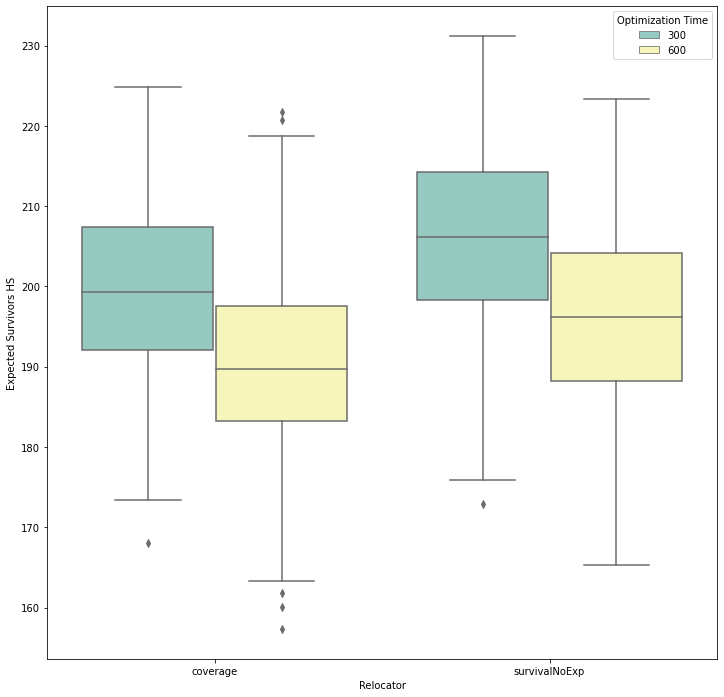

In [65]:
fig, axs = plt.subplots(1,1, figsize=(12,12))
sns.boxplot(x='Relocator', y='Expected Survivors HS', hue="Optimization Time",
                 data=df[df['Online Relocation'] == True], palette="Set3", ax=axs)
                 # Agregar el dispatching

In [35]:
df.columns

Index(['Columna1', 'Relocator', 'Dispatcher', 'Online Relocation',
       'Workload Restriction', 'Workload Limit', 'Is Uber Available',
       'ALS Tours', 'BLSTours', 'GAP', 'Optimization Time', 'Warmup time',
       'day', 'Replica', 'Uber Fraction', 'Parameters Config',
       'Emergencies Served', 'Emergencies TIS', 'Mean HS response time',
       'Mean LS response time', 'Mean LS response time No Uber',
       'Percentage ALS < 10min', 'Percentage ALS < 8min',
       'Percentage ALS < 7min', 'Uber Calls', 'Uber Response Time',
       'Expected Survivors HS', 'Average emergencies waiting',
       'Mean Meters Driven', 'Total Meters Driven', 'Server Utilization Idle',
       'Server Utilization Relocating', 'Server Utilization Attending',
       'UberFractionRevised', 'Vehicle Availability', 'Driving cost'],
      dtype='object')

In [155]:
df = pd.read_excel('dataSummary3.xlsx')
df = df.rename(columns={'Optimization Time': 'Optimization Frequency'})
df = df.replace('survivalNoExp', 'Survival')
df = df.replace('coverage', 'Coverage')
df = df.replace('nearest', 'Nearest')
df = df.replace('preparedness', 'Preparedness')
df['Configuration'] = df['Relocator'] + ' - ' + df['Dispatcher'] # + ' - ' + ['Online' if d else 'Static' for d in df['Online Relocation']]
df['Optimization Frequency'] = ['None' if not d['Online Relocation'] else str(d['Optimization Frequency']) + ' s' for _, d in df.iterrows()]

availability = {355: 1, 337: .95, 319: .9, 301: .85, 284: .8}
df['Ambulance Availability'] = [availability[d['ALS Tours']] for _, d in df.iterrows()]

In [31]:
import json
replicas = defaultdict(list)
for i, row in df.iterrows():
    replicas[str((row['day'], row['Relocator'], row['Dispatcher'], row['Online Relocation'], row['Is Uber Available'], row['Uber Fraction'], row['ALS Tours'], row['Optimization Frequency'], row['Warmup time']))].append(row['Replica'])

string = ""
for k in replicas.keys():
    string += k + ":" + str(replicas[k]) + ':' + str(len(replicas[k])) + "\n"

file1 = open("myfile.txt","w")
file1.write(string) 
file1.close() 

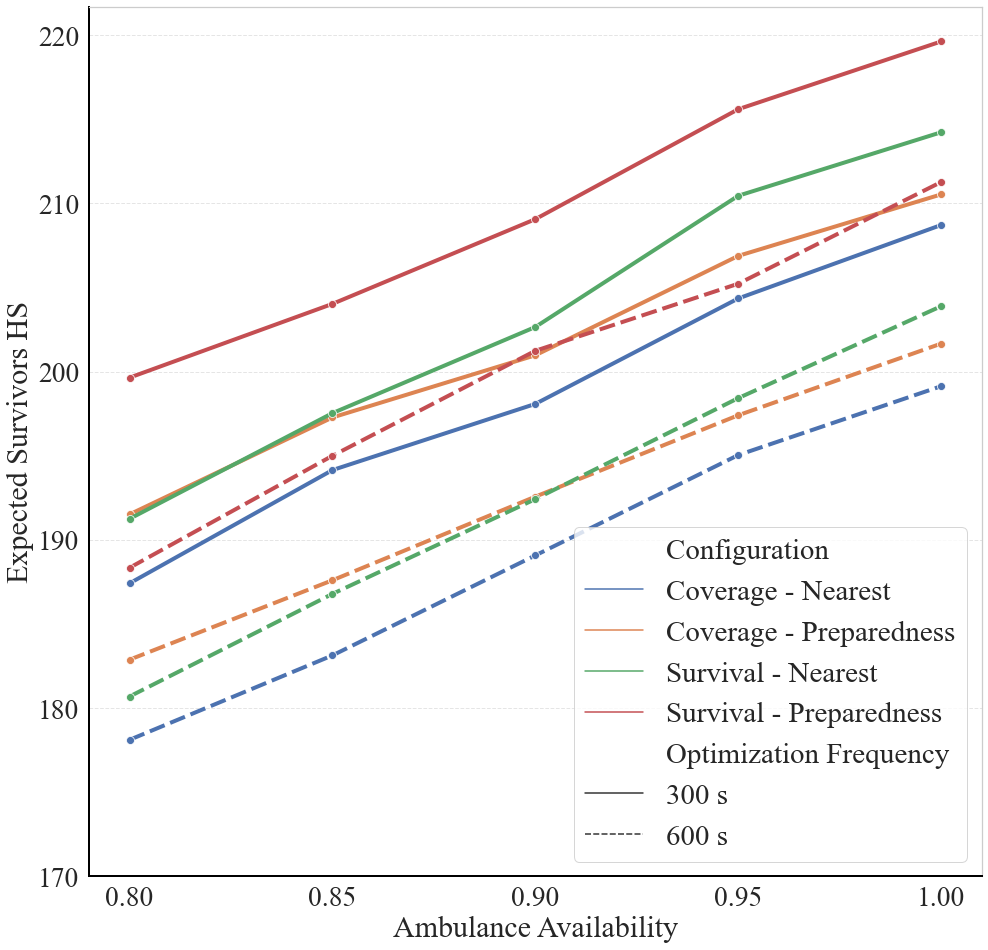

In [156]:
fig, axs = plt.subplots(1,1, figsize=(16,16))
sns.set_theme(style="whitegrid", font_scale = 3, font='Times New Roman')
#df[df['Online Relocation'] | (df['Optimization Frequency'] == 600)].groupby(['Configuration', 'Optimization Frequency', 'Vehicle Availability']).mean()['Expected Survivors HS'].unstack().T.plot(hue='Configuration', ax = axs)
#df[df['Online Relocation'] | (df['Optimization Frequency'] == 600)].groupby(['Configuration', 'Optimization Frequency', 'Vehicle Availability']).mean()['Expected Survivors HS'].unstack()
sns.lineplot(data=df[(df['day'] == 'friday') & (df['Is Uber Available'] == False) & (df['Warmup time'] == 0) & (df['Optimization Frequency'] != 'None')], x='Ambulance Availability', y='Expected Survivors HS', hue='Configuration', style='Optimization Frequency', marker='o', linewidth = 4, markersize=8, ci=None)
axs.grid(axis='x')
axs.spines['left'].set_linewidth(2)
axs.spines['left'].set_color('black')
axs.spines['bottom'].set_linewidth(2)
axs.spines['bottom'].set_color('black')
axs.grid(axis = 'y', linestyle='--', alpha= .5)#, linewidth=2)
plt.xticks([.8,.85,.9,.95,1])
plt.yticks(np.arange(170, 230, step=10))
plt.legend(fontsize=29)
fig.savefig('AvailabilityPlot.pdf', bbox_inches = 'tight', pad_inches = 0)

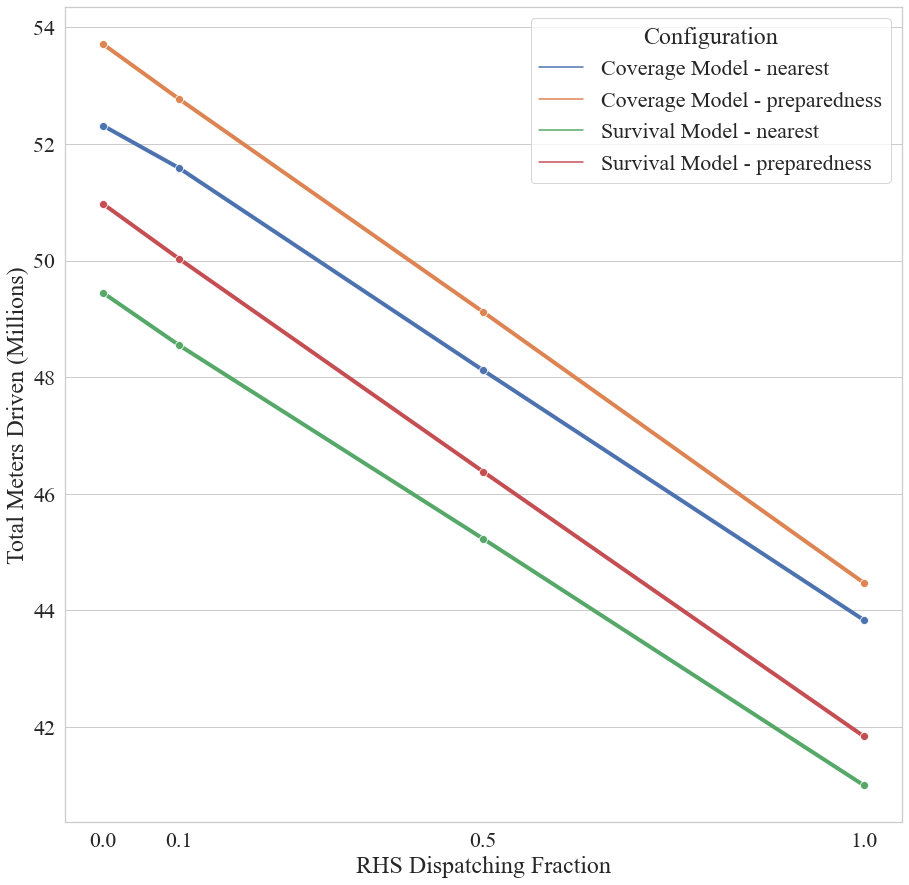

In [178]:
fig, axs = plt.subplots(1,1, figsize=(15,15))
sns.set_theme(style="whitegrid", font_scale = 2, font='Times New Roman')
#df[df['Online Relocation'] | (df['Optimization Frequency'] == 600)].groupby(['Configuration', 'Optimization Frequency', 'Vehicle Availability']).mean()['Expected Survivors HS'].unstack().T.plot(hue='Configuration', ax = axs)
#df[df['Online Relocation'] | (df['Optimization Frequency'] == 600)].groupby(['Configuration', 'Optimization Frequency', 'Vehicle Availability']).mean()['Expected Survivors HS'].unstack()
sns.lineplot(data=df[(df['day'] == 'friday') & (df['Optimization Frequency'] == '600 s') & (df['Warmup time'] == 0) & (df['Vehicle Availability']) == 1].groupby(['UberFractionRevised','Configuration']).mean(), x='UberFractionRevised', y='Total Meters Driven', hue='Configuration', marker='o', linewidth = 4, markersize=8)
axs.grid(axis='x')
axs.yaxis.get_offset_text().set_visible(False)
axs.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
axs.set(ylabel='Total Meters Driven (Millions)', xlabel='RHS Dispatching Fraction')
plt.xticks([0,.1,.5,1])
#plt.yticks(np.arange(130, 230, step=10))
fig.savefig('uberPlot.pdf', bbox_inches = 'tight', pad_inches = 0)

In [52]:
df = pd.read_excel('dataSummary2.xlsx')
df = df.rename(columns={'Optimization Time': 'Optimization Frequency'})
df = df.replace('survivalNoExp', 'Survival')
df = df.replace('coverage', 'Coverage')
df = df.replace('nearest', 'Nearest')
df = df.replace('preparedness', 'Preparedness')
df['Configuration'] = df['Relocator'] + ' - ' + df['Dispatcher'] # + ' - ' + ['Online' if d else 'Static' for d in df['Online Relocation']]
df['Optimization Frequency'] = ['None' if not d['Online Relocation'] else str(d['Optimization Frequency']) + ' s' for _, d in df.iterrows()]

availability = {355: 1, 337: .95, 319: .9, 301: .85, 284: .8}
df['Vehicle Availability'] = [availability[d['ALS Tours']] for _, d in df.iterrows()]

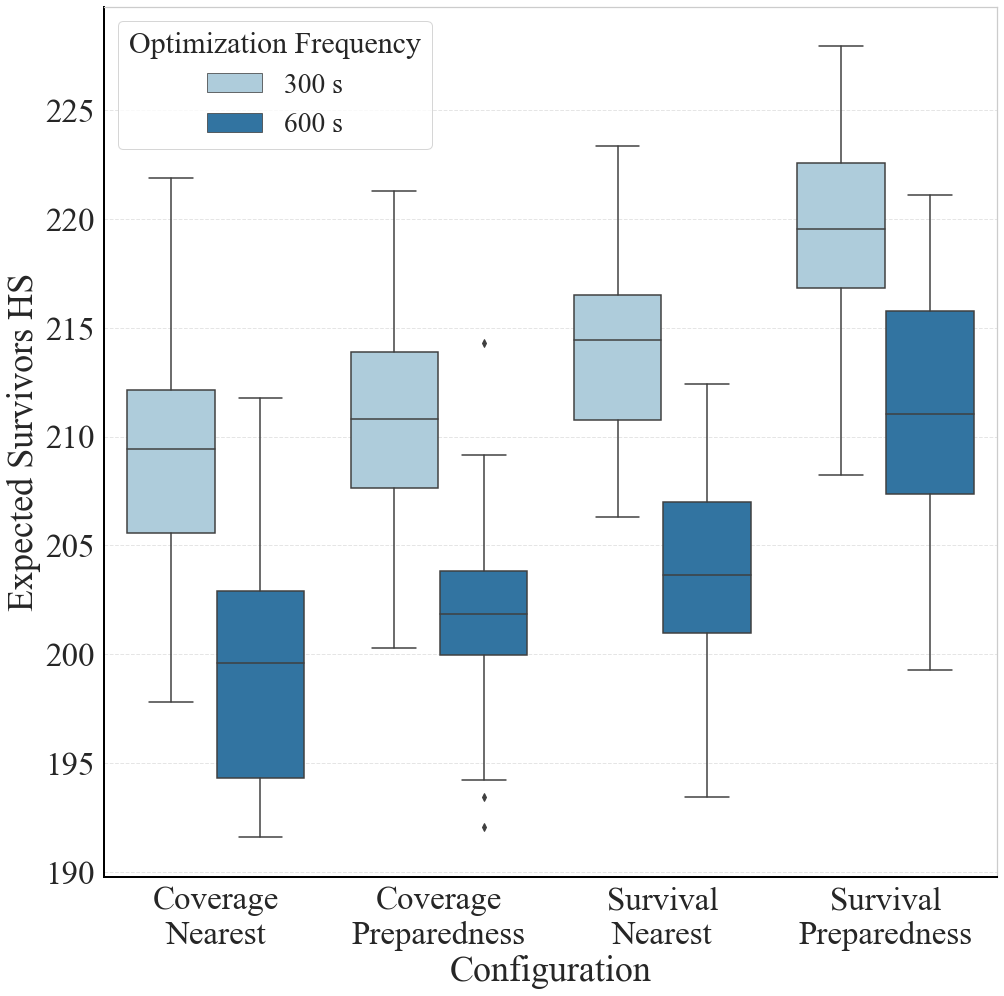

In [157]:
df['Configuration'] = df['Relocator'] + '\n' + df['Dispatcher'] # + ' - ' + ['Online' if d else 'Static' for d in df['Online Relocation']]

fig, axs = plt.subplots(1,1, figsize=(16,16))
sns.set_theme(style="whitegrid", font_scale = 2.5, font='Times New Roman')
sns.boxplot(data=df[(df['Ambulance Availability'] == 1) & (df['Is Uber Available'] == False) & (df['Optimization Frequency'] != 'None') & (df['day'] == 'friday')], x='Configuration', y='Expected Survivors HS', ax= axs, hue='Optimization Frequency', palette=sns.color_palette("Paired"))
#axs.grid(axis='x')
axs.spines['left'].set_linewidth(2)
axs.spines['left'].set_color('black')
axs.spines['bottom'].set_linewidth(2)
axs.spines['bottom'].set_color('black')
axs.grid(axis = 'y', linestyle='--', alpha= .5)
plt.xticks(rotation=0)

plt.savefig('OptimizationFrequencyBoxPlot.pdf', bbox_inches = 'tight', pad_inches = 0)

In [119]:
data = []
#for r,d,f in os.walk('D:/FTP results/'):
#    for file in f:
#        if '.pickle' in file:
#            data.append(extractStatisticsByFile('D:/FTP results/' + file))

data.append(extractStatisticsByFile('D:/FTP results/friday_0_coverage_nearest_NoRelocation_Workload_0.2_NoUber_0.05_HRDemand_284ALS642BLS.pickle'))
data.append(extractStatisticsByFile('D:/FTP results/friday_0_coverage_nearest_NoRelocation_Workload_0.2_NoUber_0.05_HRDemand_284ALS642BLS_600_86400_0.5.pickle'))

df = pd.DataFrame(data, columns=['Relocator', 'Dispatcher', 'Online Relocation', 'Workload Restriction', 'Workload Limit', 'Is Uber Available', "ALS Tours", "BLSTours", 'GAP','Optimization Time', 'Warmup time','day', 'Replica', 'Uber Fraction', 'Parameters Config', 'Emergencies Served', 'Emergencies TIS', 'Mean HS response time', 'Mean LS response time', 'Mean LS response time No Uber','Percentage ALS < 10min','Percentage ALS < 8min','Percentage ALS < 7min', 'Uber Calls', 'Uber Response Time', 'Expected Survivors HS','Average emergencies waiting', 'Mean Meters Driven', 'Total Meters Driven', 'Server Utilization Idle', 'Server Utilization Relocating', 'Server Utilization Attending'])
data
df.to_excel('test.xlsx')

NameError: name 'extractStatisticsByFile' is not defined

In [24]:
with open('StatisticsResults/friday_0_survivalNoExp_preparedness_Relocate_Workload_0.2_NoUber_0.05_HRDemand_355ALS802BLS_600_129600.pickle', 'rb') as f:
    statistics = pickle.load(f)

In [12]:
rel = ['coverage', 'survivalNoExp']
dispa = ['preparedness', 'nearest']
relocate = [True, False]
day = ['friday', 'monday']
replica = [0,1,2,3,5]

data = []
for element in itertools.product(rel, dispa, relocate, day, replica):
    data.append(extractStatistics(element[0], element[1], element[2], day=element[3], replica=element[4], workload_limit=.2))
df = pd.DataFrame(data, columns=['Relocator', 'Dispatcher', 'Online Relocation', 'Workload Restriction', 'Workload Limit', 'Is Uber Available', "ALS Tours", "BLSTours", 'GAP','day', 'Replica', 'Parameters Config', 'Emergencies Served', 'Emergencies TIS', 'Mean HS response time', 'Mean LS response time', 'Percentage ALS < 10min','Percentage ALS < 8min','Percentage ALS < 7min', 'Uber Calls', 'Uber Response Time', 'Expected Survivors HS','Average emergencies waiting'])


In [47]:
df.groupby(['Relocator', 'Dispatcher', 'Online Relocation', 'Workload Restriction', 'Workload Limit', 'Is Uber Available', "ALS Tours", "BLSTours", 'GAP','day', 'Parameters Config']).mean()

monday HRDemand             0.000000   
                                                                                                                      43200 friday HRDemand             0.000000   
                                                                                                                            monday HRDemand             0.000000   
                                                                                                   301       681      0     friday HRDemand             0.000000   
...                                                                                                                                                          ...   
survivalNoExp preparedness True              True                 0.2            True              337       761      43200 monday HRDemand            97.933333   
                                                                                                   355       802      0     friday HRDemand           429.333333   
                                                                                                                            monday HRDemand           420.131148   
                                                                                                                      43200 friday HRDemand           109.733333   
                                                                                                                            monday HRDemand            94.133333   

                                                                                                                                                      Uber Response Time  \
Relocator     Dispatcher   Online Relocation Workload Restriction Workload Limit Is Uber Available ALS Tours BLSTours GAP   day    Parameters Config                       
coverage      nearest      False             True                 0.2            False             284       642      0     friday HRDemand                     0.000000   
                                                                                                                            monday HRDemand                     0.000000   
                                                                                                                      43200 friday HRDemand                          NaN   
                                                                                                                            monday HRDemand                          NaN   
                                                                                                   301       681      0     friday HRDemand                     0.000000   
...                                                                                                                                                                  ...   
survivalNoExp preparedness True              True                 0.2            True              337       761      43200 monday HRDemand                   542.431698   
                                                                                                   355       802      0     friday HRDemand                   550.215310   
                                                                                                                            monday HRDemand                   549.003990   
                                                                                                                      43200 friday HRDemand                   538.888298   
                                                                                                                            monday HRDemand                   551.180070   

                                                                                                                                                      Expected Survivors HS  \
Relocator     Dispatcher   Online Relocation Workload Restriction Workl

In [149]:
dfaa = pd.DataFrame([['1', '2'], ['3', '4']])
aux = dfaa.loc[0]
df2 = pd.DataFrame([['a'], [0]])
df2.iloc[1] = aux
df2.iloc[1][0] = 1000
dfaa

0  1
0  1  2
1  3  4

In [41]:
statistics[1]['Ambulance 1']['Statistics']['State'].data

[(0, 0),
 (2076.0, 2),
 (4686.602434242028, 0),
 (4686.602434242028, 1),
 (4708.940559425023, 1),
 (4721.423169032832, 1),
 (4760.889298089473, 1),
 (4770.0855701262635, 1),
 (4779.649588453293, 1),
 (4789.286258514089, 1),
 (4799.673686296044, 1),
 (4810.095689378163, 1),
 (4822.604969116579, 1),
 (4836.73262075538, 1),
 (4846.708867431916, 1),
 (4847.823474021655, 1),
 (4855.0075644064855, 1),
 (4865.509597901, 1),
 (4875.770579699571, 1),
 (4886.1424103393565, 1),
 (4896.15558036491, 1),
 (4906.336625165845, 1),
 (4916.273296103068, 1),
 (4927.192263047235, 1),
 (4939.2271125675015, 1),
 (4961.135552737542, 1),
 (4982.067517234728, 1),
 (4984.545043553517, 1),
 (5009.865455102, 1),
 (5017.291621065254, 1),
 (5031.8580446758915, 1),
 (5072.067519466429, 1),
 (5075.208904305365, 1),
 (5083.174447959196, 1),
 (5086.251519806519, 1),
 (5093.117755285021, 1),
 (5099.035511521512, 1),
 (5108.754456530899, 1),
 (5119.511534083423, 1),
 (5130.913106760545, 1),
 (5141.229971485797, 1),
 (515

In [37]:
3600 * 24

86400

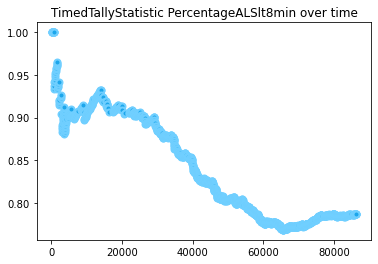

In [7]:
#fig, ax = plt.subplots(1,1, figsize=(15,15))

with open('StatisticsResults/friday_0_coverage_nearest_NoRelocation_Workload_0.4_NoUber_0.05.pickle', 'rb') as f:
    statistics = pickle.load(f)
    
#statistics[0]['TravelTime'].average(),np.std([d[1] for d in statistics[0]['TravelTime'].data])

#visualizeSpatialStatistic(ax, nyc_boundaries, statistics[0]['SpatialALSRelocation'].data, nyc_graph_nodes, candidate_points, quantile_clip=1, default=0, method='points', legend=True)
#plt.hist([d[1] for d in statistics[0]['HSresponseTime'].data], bins=100)
#statistics[1]['Ambulance 57']['Statistics']['State'].visualize()
statistics[0]['PercentageALSlt8min'].visualize()
#statistics[0]['GAPALSPart1'].visualize()

#visualizeStateStatisticData(statistics[0]['AvailableALSVehicles'].data[1:])

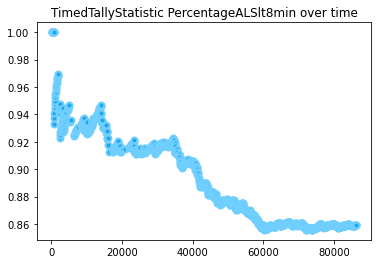

In [517]:
#fig, ax = plt.subplots(1,1, figsize=(15,15))

with open('StatisticsResults/friday_0_coverage_preparedness_Relocate_Workload_0.4_NoUber_0.05.pickle', 'rb') as f:
    statistics = pickle.load(f)

#visualizeSpatialStatistic(ax, nyc_boundaries, statistics[0]['SpatialALSRelocation'].data, nyc_graph_nodes, candidate_points, quantile_clip=1, default=0, method='points', legend=True)
statistics[0]['PercentageALSlt8min'].visualize()
#statistics[0]['TravelTime'].average(),np.std([d[1] for d in statistics[0]['TravelTime'].data])
#plt.hist([d[1] for d in statistics[0]['HSresponseTime'].data], bins=100)
#statistics[1]['Ambulance 1']['Statistics']['State'].visualize()
#statistics[1]['Ambulance 1']['Record']
#statistics[1]['Ambulance 1']['Record'][0][3].node
#print(statistics[0]['SpatialALSRelocation'].data)
#statistics[0]['GAPALSPart1'].visualize()

#A = mapGraphNodesDataToUniformDemand([(d[1], d[2]) for d in statistics[0]['SpatialALSRelocation'].data], demand_points, nyc_graph_nodes, agg='avg', default=0, value_col='value')
#A[~A['value'].isin([0, 1])]
#visualizeStateStatisticData(statistics[0]['AvailableALSVehicles'].data[1:])
#statistics[0]['AvailableALSVehicles'].visualize()

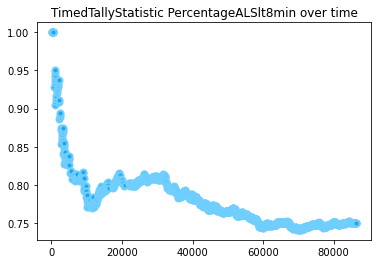

In [519]:
#fig, ax = plt.subplots(1,1, figsize=(15,15))

with open('StatisticsResults/friday_0_survival_preparedness_NoRelocation_Workload_0.4_NoUber_0.05.pickle', 'rb') as f:
    statistics = pickle.load(f)

#visualizeSpatialStatistic(ax, nyc_boundaries, statistics[0]['SpatialALSRelocation'].data, nyc_graph_nodes, candidate_points, quantile_clip=1, default=0, method='points', legend=True)
statistics[0]['PercentageALSlt8min'].visualize()
#statistics[0]['TravelTime'].average(),np.std([d[1] for d in statistics[0]['TravelTime'].data])
#plt.hist([d[1] for d in statistics[0]['HSresponseTime'].data], bins=100)
#statistics[1]['Ambulance 1']['Statistics']['State'].visualize()
#statistics[1]['Ambulance 1']['Record']
#statistics[1]['Ambulance 1']['Record'][0][3].node
#print(statistics[0]['SpatialALSRelocation'].data)
#statistics[0]['GAPALSPart1'].visualize()

#A = mapGraphNodesDataToUniformDemand([(d[1], d[2]) for d in statistics[0]['SpatialALSRelocation'].data], demand_points, nyc_graph_nodes, agg='avg', default=0, value_col='value')
#A[~A['value'].isin([0, 1])]
#visualizeStateStatisticData(statistics[0]['AvailableALSVehicles'].data[1:])
#statistics[0]['AvailableALSVehicles'].visualize()

(array([ 57.,  37.,  49.,  45.,  76.,  92.,  89., 108., 111., 114., 114.,
        119., 101., 117., 128., 109., 108., 110., 106.,  92.,  91.,  88.,
         74., 112.,  97., 104., 116.,  92., 112., 100.,  94., 102.,  85.,
        114.,  87.,  83.,  16.,   5.,  12.,   8.,  13.,   3.,   3.,   3.,
          8.,   3.,   1.,   2.,   3.,   4.,   1.,   1.,   1.,   1.,   0.,
          1.,   2.,   0.,   1.,   1.,   3.,   0.,   1.,   0.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([   0.        ,   13.41107886,   26.82215771,   40.23323657,
          53.64431543,   67.05539428,   80.46647314,   93.87755199,
         107.28863085,  120.69970971,  134.11078856,  147.52186742,
         160.93294628,  174.34402513,  187.75510399,  201.16618284,
         214.5772617 ,  227.98834056,  241.399

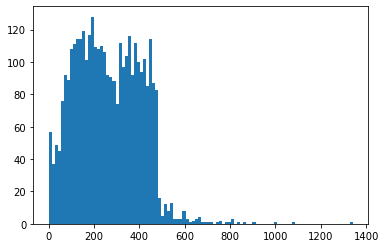

In [489]:
with open('StatisticsResults/Old/friday_0_coverage_preparedness_Relocate_Workload_0.4_NoUber_0.05.pickle', 'rb') as f:
    statistics = pickle.load(f)
plt.hist([d[1] for d in statistics[0]['TravelTime'].data], bins = 100)

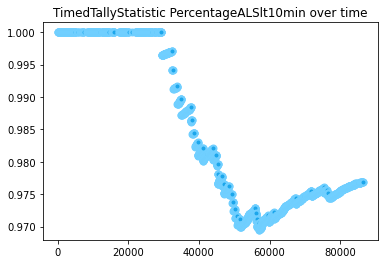

In [298]:
with open('StatisticsResults/friday_0_survival_preparedness_Relocate_Workload_0.4_NoUber.pickle', 'rb') as f:
    statistics = pickle.load(f)
#plt.hist([d[1] for d in statistics[0]['LSresponseTime'].data], bins = 100)
#statistics[1]['Ambulance 4']['Statistics']['State'].visualize()
statistics[0]['PercentageALSlt10min'].visualize()

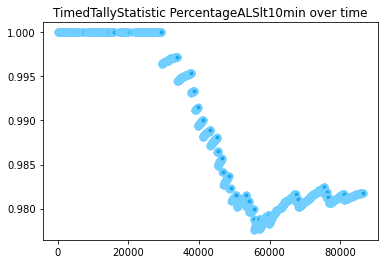

In [130]:
statistics[0]['PercentageALSlt10min'].visualize()

In [37]:
len([(d[1], d[2]) for d in statistics[0]['SpatialHSAverageResponseTime'].data])

1430

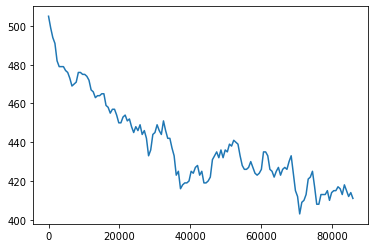

In [5]:
#[d[1] for S in [statistics[0]['OptimizationSizeALS{}'.format(i)] for i in range(1,6)] for d in S.data]
plt.plot([data[0] for data in statistics[0]['OptimizationSizeBLS1'].data],
[sum(d[1] for S in [statistics[0]['OptimizationSizeBLS{}'.format(i)] for i in range(1,6)] for d in S.data if d[0] == data[0]) for data in statistics[0]['OptimizationSizeBLS1'].data])

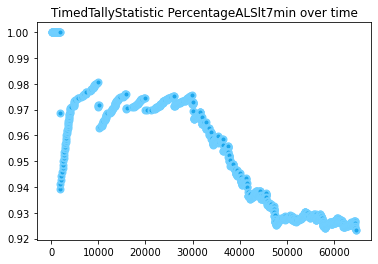

In [112]:
statistics[0]['PercentageALSlt7min'].visualize()

(array([ 42.,  25.,  35.,  38.,  57.,  76.,  71.,  89.,  86.,  95., 102.,
         89., 116., 107.,  94.,  86., 103.,  84.,  81.,  66.,  73.,  66.,
         77.,  71.,  79.,  73.,  82.,  72.,  76.,  72.,  78.,  77.,  69.,
         12.,   4.,   6.,   7.,   1.,   4.,   1.,   3.,   1.,   2.,   3.,
          1.,   1.,   3.,   1.,   2.,   0.,   2.,   1.,   3.,   2.,   0.,
          2.,   0.,   1.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([   0.        ,   14.55520018,   29.11040036,   43.66560055,
          58.22080073,   72.77600091,   87.33120109,  101.88640127,
         116.44160145,  130.99680164,  145.55200182,  160.107202  ,
         174.66240218,  189.21760236,  203.77280254,  218.32800273,
         232.88320291,  247.43840309,  261.993

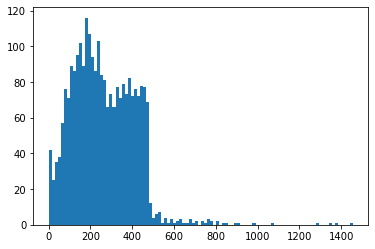

In [115]:
plt.hist([d[1] for d in statistics[0]['TravelTime'].data], bins = 100)

In [86]:
np.array([d[1] for d in statistics[0]['TravelTime'].data]).mean()

291.14943948489235

(array([11.,  9., 19., 18., 27., 43., 70., 69., 56., 60., 76., 73., 74.,
        93., 81., 70., 74., 61., 93., 69., 71., 56., 55., 58., 53., 47.,
        47., 36., 44., 41., 36., 27., 21., 23., 19., 19., 12., 17., 12.,
         8., 12., 11.,  9.,  6.,  4.,  6.,  3.,  5.,  3.,  2.,  2.,  1.,
         1.,  2.,  1.,  2.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,
         0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  2.,  0.,  3.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         2.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  2.]),
 array([  10.34417482,   31.86692052,   53.38966623,   74.91241193,
          96.43515763,  117.95790334,  139.48064904,  161.00339475,
         182.52614045,  204.04888615,  225.57163186,  247.09437756,
         268.61712326,  290.13986897,  311.66261467,  333.18536038,
         354.70810608,  376.23085178,  397.75359749,  419.27634319,
         440.7990889 ,  462.3218346 ,  483.8445803 ,  505.36732601,
         526.89007171,  54

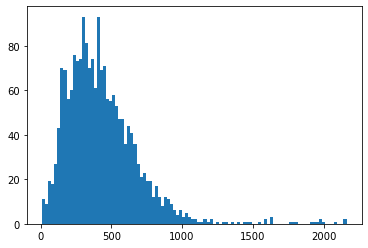

In [72]:
plt.hist([d[1] for d in statistics[0]['ToHospitalTime'].data], bins = 100)

In [87]:
np.array([d[1] for d in statistics[0]['ToHospitalTime'].data]).mean()

432.6503422684321

(array([21., 47., 70., 99., 66., 47., 74., 75., 50.,  8.,  5., 15.,  7.,
         7., 16., 17., 19., 21., 28., 28., 37., 43., 37., 46., 55., 47.,
        59., 58., 68., 65., 65., 61., 65., 53., 61., 59., 60., 54., 43.,
        42., 58., 56., 50., 35., 35., 33., 32., 39., 28., 31., 19., 37.,
        20., 23., 15., 16., 25., 15., 16.,  9.,  8.,  5.,  7., 11.,  4.,
         8.,  4.,  9.,  8., 10.,  3.,  2.,  3.,  1.,  6.,  5.,  3.,  2.,
         3.,  2.,  1.,  1.,  3.,  2.,  1.,  1.,  2.,  0.,  0.,  0.,  2.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([   0.        ,   54.00379827,  108.00759655,  162.01139482,
         216.0151931 ,  270.01899137,  324.02278965,  378.02658792,
         432.0303862 ,  486.03418447,  540.03798275,  594.04178102,
         648.04557929,  702.04937757,  756.05317584,  810.05697412,
         864.06077239,  918.06457067,  972.06836894, 1026.07216722,
        1080.07596549, 1134.07976377, 1188.08356204, 1242.08736031,
        1296.09115859, 135

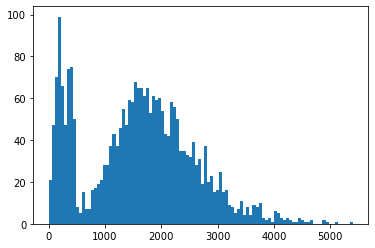

In [116]:
plt.hist([d for d in statistics[0]['EmergenciesTimeInSystem'].data], bins = 100)

(array([ 4.,  8., 11., 14., 16., 33., 40., 37., 41., 43., 40., 47., 49.,
        50., 57., 62., 46., 52., 53., 54., 57., 62., 57., 59., 63., 75.,
        50., 54., 56., 50., 60., 41., 34., 43., 35., 33., 34., 28., 28.,
        26., 25., 19., 17., 18., 18., 16., 18., 16., 13., 11., 11., 10.,
         6.,  9.,  5., 13., 13.,  5.,  7.,  6.,  4.,  9.,  3.,  2.,  1.,
         6.,  2.,  1.,  2.,  1.,  3.,  1.,  1.,  2.,  1.,  0.,  1.,  0.,
         1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  84.97548258,  132.28379012,  179.59209766,  226.90040519,
         274.20871273,  321.51702027,  368.8253278 ,  416.13363534,
         463.44194288,  510.75025042,  558.05855795,  605.36686549,
         652.67517303,  699.98348056,  747.2917881 ,  794.60009564,
         841.90840317,  889.21671071,  936.52501825,  983.83332578,
        1031.14163332, 1078.44994086, 1125.75824839, 1173.06655593,
        1220.37486347, 126

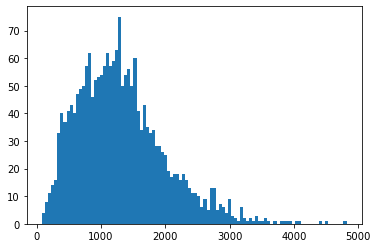

In [75]:
plt.hist([d[1] for d in statistics[0]['LSAttentionTime'].data + statistics[0]['HSAttentionTime'].data if d[1] > 0], bins = 100)

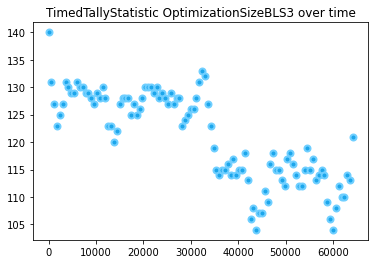

In [117]:
statistics[0]['OptimizationSizeBLS3'].visualize()

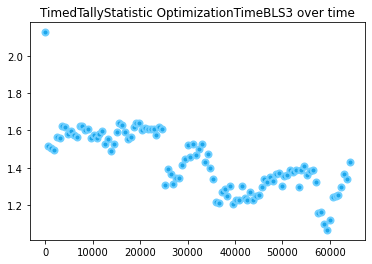

In [118]:
statistics[0]['OptimizationTimeBLS3'].visualize()

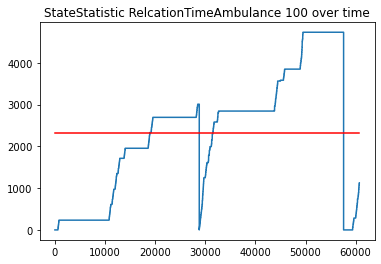

In [120]:
statistics[1]['Ambulance 100']['RelocationTime'].visualize()

In [107]:
statistics[0]['EmergenciesServed'].data

1944

In [337]:
demand_points.loc[0, 'geometry'].coords[0]

(-73.90541332463452, 40.90837854306597)